Data Generation and Augmentation with Generative AI ---  and then train on this data and compare the accuracy.

--> Using a Generative Adversarial Network (GAN) to create high-quality synthetic data for fraudulent credit card transactions. We will use this synthetic data to augment a real dataset, train a more robust machine learning model, and significantly improve its ability to catch fraud.


1. Project Goal & Dataset
    To improve the performance (specifically Recall and F1-score) of a fraud detection classifier by generating synthetic data for the underrepresented "fraud" class. As there is very less data for fraud class, if we generate more synthetics data , then it will be usefull as now our model will flag fraud very frequently and upto some extent we want that to happen.

    About dataset ----

    We'll use the Credit Card Fraud Detection dataset, which is publicly available on Kaggle.

    It contains 30 numerical features. Time and Amount are explicit, while V1 through V28 are anonymized features resulting from a PCA transformation to protect user privacy.
    The Class column, where 0 means normal and 1 represents a fraud.
    The Challenge: The dataset is severely imbalanced. Fraudulent transactions make up only about 0.17% of the total, making it very difficult for a standard model to learn their patterns.
2. Tech stack
    Pandas: For data manipulation.
    Scikit-learn: For data preprocessing and model training.
    SDV (Synthetic Data Vault): The library containing the generative model -- CTGAN.
    Matplotlib & Seaborn: For data visualization.
    XGBoost: A powerful classification model that we'll use.
3. Exploratory Data Analysis (EDA)
    Before we generate data, we need to understand the data we have. This step involves loading the data and visualizing it (undertstanding the data).

4. Synthetic Data Generation with CTGAN
    We will use a Conditional Tabular GAN (CTGAN) to learn the patterns only from the fraudulent transactions and then generate new, realistic fraud samples.
    Our goal is to oversample only the minority class. If we trained the GAN on the entire dataset, it would mostly learn to generate #normal transactions#, which we already have plenty of. By focusing it on the rare fraud examples, we force it to become an expert at creating just the data we need.
5. Data Augmentation and Model Preparation
    Now, we combine our newly generated synthetic fraud data with the original dataset. This creates a more balanced dataset for training our classifier.

    We will use this augmented dataset to train our final model. But to evaluate its performance, we must test it on original data. We will create a separate test set from the original data for the final evaluation

6. Model Training & Evaluation
    We will train two XGBoost models:
    Model A (Original with less frauds): Trained on the original data.
    Model B (Augmented): Trained on our new balanced data.
    We will then compare their performance on the same unseen test data to see the impact of our synthetic data.




Finally we also plot a PCA plot to view the feature in 2 dimension that are these newly generated fraud samples close to previous ones or is it a bad model ( new genrated are scattered far away from original one ) ( they must be close)



  Very important observation in this project

  Your dataset is over 99% non-fraudulent. A lazy model that predicts "not fraud" for every single transaction would still have 99.8% accuracy! Accuracy is a misleading metric here.

  Precision, recall, and F1-score of the minority class are better metrics.



  I think recall matters a lot here , rather than precision or accuracy or f1 score ,, why ??
  Imagine your fraud detection model is an airport security scanner looking for dangerous items (fraud).
  Recall: This is the scanner's ability to find all the actual dangerous items. If there are 100 dangerous items that go through, and the scanner finds 88 of them, the recall is 88%. High recall is critical  you don't want to miss any real threats.

  Precision: This is about not having false alarms. If the scanner's alarm goes off 100 times, but only 32 of those were for actually dangerous items, the precision is 32%. It means you're stopping and checking innocent people constantly, which is little frustrating.

  F1-Score: This is the balance between recall and precision. A high F1-score means you have a good balance of both. A low score means you are sacrificing one too much for the other.







  IMPORTANT CONCLUSION -- when I added 5000 new fraud example using CTGAN , the recal was of course increased but precesion and f1 decreases drastically ( reduced to almost halves)  but I  tried with differnet amounts and with 1000 new examples , scores are pretty amazing.




(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

/tmp/ipython-input-3893610029.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='pastel')


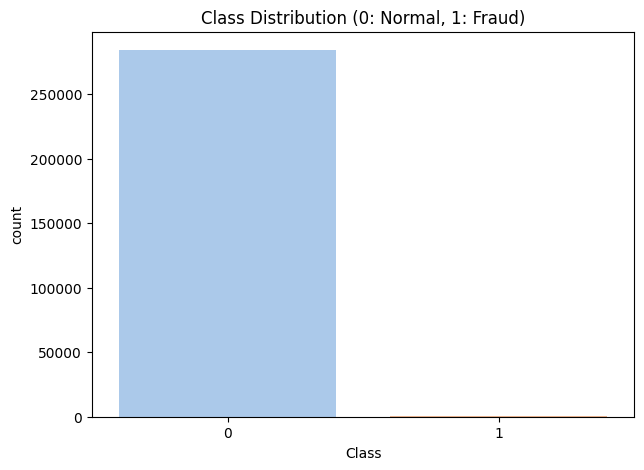

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("/content/creditcard.csv")

print(df.shape)
print(df.head())
a = df['Class']
zero_class,one_class = 0,0
for i in range(len(a)):
  if a[i] == 0:
    zero_class+=1
  else:
    one_class+=1
print(zero_class,one_class)
print("Percentage of fraud class:-",(one_class/zero_class) * 100)
#visualization of class imbalance
plt.figure(figsize=(7, 5))
sns.countplot(x='Class', data=df, palette='pastel')
plt.title('Class Distribution (0: Normal, 1: Fraud)')
plt.show()

In [20]:
# !pip install sdv
# !pip install ctgan
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer,TVAESynthesizer
from sdv.evaluation.single_table import evaluate_quality
# # 1. Isolate the real fraud data
fraud_data = df[df['Class'] == 1]



In [21]:
#train the CTGAN model
# run for more epochs to ensure it learns the patterns well


#metadata is a machine-readable description of your table (columns, types, constraints, keys, relationships).
# SDV uses it so the synthesizer knows how to model each column instead of guessing.
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(fraud_data)


ctgan_model = CTGANSynthesizer(metadata,epochs=500, verbose=True)
## Training CTGAN on real fraud data
ctgan_model.fit(fraud_data)
# training complete

# Generate synthetic fraud samples
# generate 5,000 new fraud samples for now
num_synthetic_samples = 1000
synthetic_fraud = ctgan_model.sample(num_synthetic_samples)

print(synthetic_fraud.head())

score = evaluate_quality(synthetic_fraud, df.sample(num_synthetic_samples),metadata)
print(score)


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:167: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:133: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-1.61) | Discrim. (-0.20): 100%|██████████| 500/500 [01:21<00:00,  6.12it/s]


       Time         V1        V2         V3        V4         V5        V6  \
0  167169.0  -1.971803  2.412188 -12.861923 -0.283979 -17.698560 -1.390569   
1   88689.0   2.132386  5.980459  -9.579365  3.269460  -6.950841 -0.678954   
2  155965.0  -1.022821 -2.234782 -10.227802  4.102779  -7.760396 -2.702289   
3  142729.0  -8.330278 -4.419166  -4.142179  6.099354 -22.105532 -0.656294   
4  170154.0 -23.974495 -0.228668 -22.155965  3.225778  -1.918045 -3.370653   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0 -2.445461 -0.578415  3.353525  ... -0.540740  0.048624  0.003242  0.671198   
1  2.495916 -1.871148 -2.959152  ... -0.379660 -1.006846 -4.950572 -0.196857   
2 -0.911199  2.912222  0.919231  ... -1.866241  1.133532 -0.983768 -1.244974   
3 -0.255066  1.415036 -4.086213  ...  0.028817  2.165641 -1.010961 -0.738569   
4 -8.080305 -3.050390  1.363033  ... -1.731499  1.369800  0.963146  0.116176   

        V25       V26       V27       V28  Amount 

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## z-normalize the data , so that most values are centered around 0 ( more formally  -- they are  closer so easy for model to train/converge)


augmented_df = pd.concat([df, synthetic_fraud], ignore_index=True) ## augment ( combine datas)
# also shuffle it // make it random
augmented_df = augmented_df.sample(frac=1, random_state=42).reset_index(drop=True)

## let's again see counts
a = augmented_df['Class']
zero_class,one_class = 0,0
for i in range(len(a)):
  if a[i] == 0:
    zero_class+=1
  else:
    one_class+=1
print(zero_class,one_class)
print("Percentage of fraud class:-",(one_class/zero_class) * 100)


284315 1492
Percentage of fraud class:- 0.5247700613755869


In [23]:
# Separate features (X) and target (y)
X = augmented_df.drop('Class', axis=1)
y = augmented_df['Class']

# 4. Scale the features
# The 'Amount' and 'Time' columns are on a different scale than V1-V28
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)



Baseline Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.91      0.76      0.83       123

    accuracy                           1.00     71202
   macro avg       0.96      0.88      0.92     71202
weighted avg       1.00      1.00      1.00     71202


Augmented Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.86      0.93      0.89       123

    accuracy                           1.00     71202
   macro avg       0.93      0.96      0.95     71202
weighted avg       1.00      1.00      1.00     71202



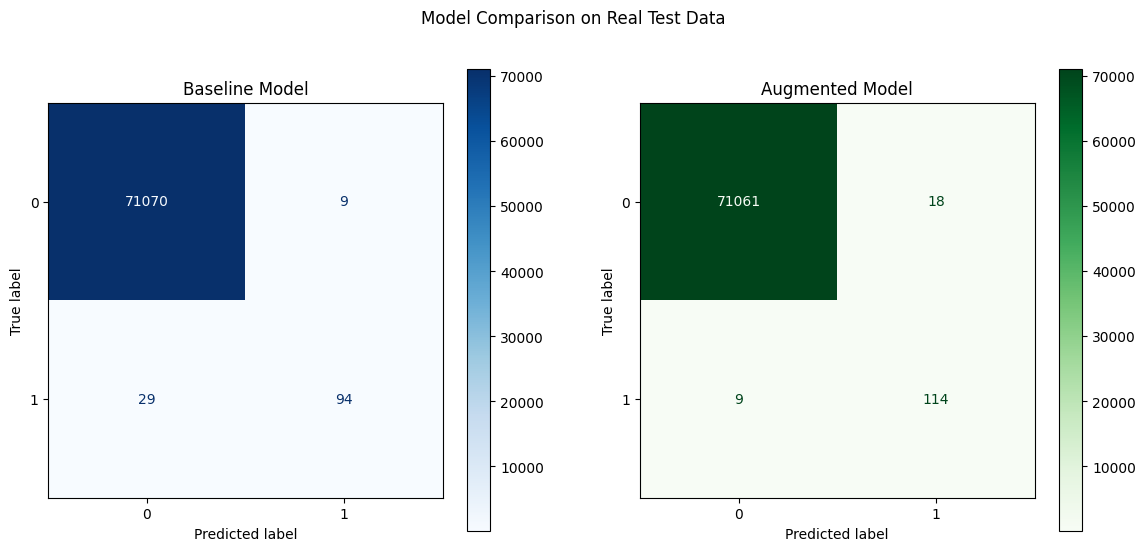

In [24]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_orig = df.drop('Class', axis=1)
y_orig = df['Class']

# Scale original data
X_orig_scaled = scaler.fit_transform(X_orig)
X_train_orig , X_test_orig, y_train_orig , y_test_orig = train_test_split(X_orig_scaled, y_orig, test_size=0.25, random_state=42, stratify=y_orig)

# Model A: Trained on Original Imbalanced Data
## Training Baseline Model (Original Data)
baseline_model = XGBClassifier(random_state=42)
#baseline_model = RandomForestClassifier(random_state=42,n_jobs = -1)
baseline_model.fit(X_train_orig, y_train_orig)
y_pred_baseline = baseline_model.predict(X_test_orig)

print("\nBaseline Model Performance:")
print(classification_report(y_test_orig, y_pred_baseline))


#Model B: Trained on Augmented Data
augmented_model = XGBClassifier(random_state=42)
#augmented_model = RandomForestClassifier(random_state=42,n_jobs = -1)
augmented_model.fit(X_train, y_train)
y_pred_augmented = augmented_model.predict(X_test_orig) # But test on the ORIGINAL test set

print("\nAugmented Model Performance:")
print(classification_report(y_test_orig, y_pred_augmented))


#Visualizing the difference with a Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Comparison on Real Test Data')


# Baseline Confusion Matrix
ConfusionMatrixDisplay.from_estimator(baseline_model, X_test_orig, y_test_orig, ax=axes[0], cmap='Blues')
axes[0].set_title('Baseline Model')

# Augmented Confusion Matrix
ConfusionMatrixDisplay.from_estimator(augmented_model, X_test_orig, y_test_orig, ax=axes[1], cmap='Greens')
axes[1].set_title('Augmented Model')

plt.show()

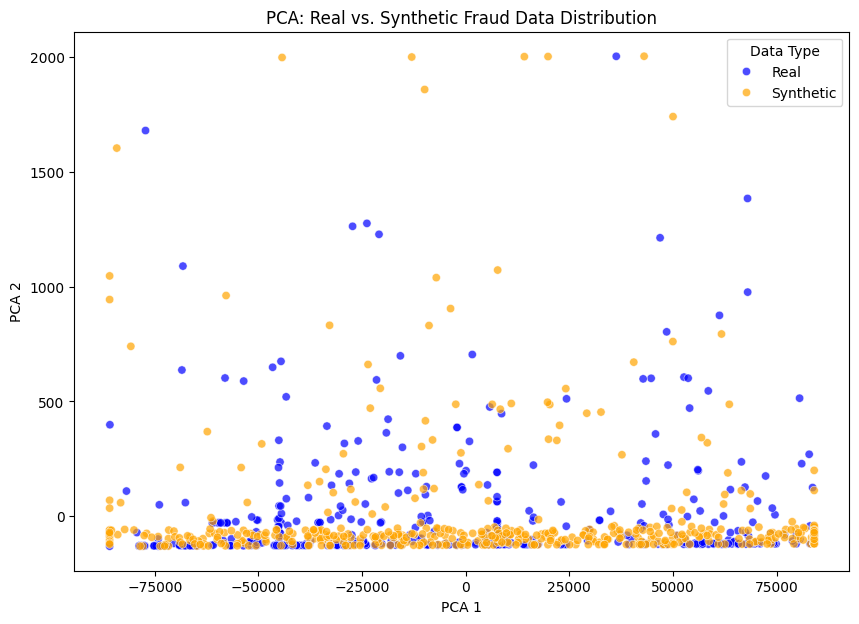

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
#Visualization of Real vs. Synthetic Data

real_fraud_sample = fraud_data.sample(n=min(len(fraud_data), 500), random_state=42)
synthetic_fraud_sample = synthetic_fraud.sample(n=min(len(synthetic_fraud), 500), random_state=42)
# Combine the samples for PCA fitting
combined_data = pd.concat([real_fraud_sample, synthetic_fraud_sample], ignore_index=True)
combined_data_no_class = combined_data.drop('Class', axis=1)

# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data_no_class)
# Add PCA results and labels to a new DataFrame for plotting
plot_df_pca = pd.DataFrame(data=pca_result, columns=['PCA 1', 'PCA 2'])
plot_df_pca['Data Type'] = ['Real'] * len(real_fraud_sample) + ['Synthetic'] * len(synthetic_fraud_sample)
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA 1', y='PCA 2', hue='Data Type', data=plot_df_pca, alpha=0.7, palette=['blue', 'orange'])
plt.title('PCA: Real vs. Synthetic Fraud Data Distribution')
plt.show()



In [26]:

# import pickle
# with open('fraud_detection_model.pkl', 'wb') as file:
#     pickle.dump(augmented_model, file)

In [27]:
# synthetic_fraud.to_csv('synthetic_fraud_data.csv', index=False)

# from google.colab import files
# files.download('synthetic_fraud_data.csv')

Synthetic fraud data saved to 'synthetic_fraud_data.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:

augmented_df.to_csv('augmented_dataset.csv', index=False)
print("Augmented dataset saved to 'augmented_dataset.csv'")

from google.colab import files
files.download('augmented_dataset.csv')

Augmented dataset saved to 'augmented_dataset.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>